# Image Segmentation

## Semantic Segmentation

## Instance Segmentation

## Datasets:

* Pascal VOC:
    ** 2012 Version
        ** 2,900 images
        ** 6,900 objects
        
* COCO
    ** 2017 Version
        ** 123,000 images
        ** 886,000 objects
        ** 80 classes
        
In Semantic Segmentation,  COCO uses only 20 class from 80 classes

* ADE20K
    ** 2016 Version
        ** 20,000 images
        ** 400,000 objects
        ** 150 classes in total

## Models

* FCN with ResNet
* PSP with ResNet
* Deeplab with ResNet

In [13]:
import mxnet as mx
import gluoncv as gcv
import matplotlib.pyplot as plt

In [14]:
# Load image
image = mx.image.imread('dog.jpg')
print("Image shape", image.shape) # Height, Width, Channel shape
print("Image dtype", image.dtype) # Unsigned 8 bit Integers
print("Image min", image.min().asscalar()) # Minimum pixel value in the image
print("Image max", image.max().asscalar()) # Maximum pixel value in the image

Image shape (576, 768, 3)
Image dtype <class 'numpy.uint8'>
Image min 0
Image max 255


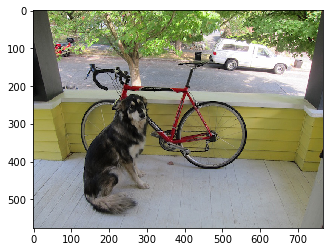

In [15]:
# Visualize image
plt.imshow(image.asnumpy())

In [16]:
# Transform Image
from mxnet.gluon.data.vision import transforms

transform_fn = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize([.485, .456, .406],
                                       [.229, .224, .225])
                    ])

ToTensor = converts data from HWC to CHW

Normalize = normalize using ImageNet1k Statistics

In [17]:
image = transform_fn(image)

In [18]:
print("Image shape", image.shape) # Height X Width X Channel shape
print("Image dtype", image.dtype) # Unsigned 8 bit Integers
print("Image min", image.min().asscalar()) # Minimum pixel value in the image
print("Image max", image.max().asscalar()) # Maximum pixel value in the image

Image shape (3, 576, 768)
Image dtype <class 'numpy.float32'>
Image min -2.117904
Image max 2.64


In [19]:
# Batch Image
image =  image.expand_dims(axis=0)
print(image.shape)

(1, 3, 576, 768)


In [20]:
# Load Models
# FCN Network with ResNet backbone trained as ADE20k dataset
network = gcv.model_zoo.get_model('fcn_resnet50_ade', pretrained=True)

57418KB [00:30, 1897.30KB/s]                                                                                           


128832KB [01:07, 1902.15KB/s]                                                                                          


In [22]:
# Make Prediction
output = network.predict(image)
print(output.shape)

(1, 150, 576, 768)


In [23]:
output = output[0]
print(output.shape) # We have 150 channels because we have 150 classes in ADE20k dataset

(150, 576, 768)


In [24]:
# Closer Look: For Pixel Size
px_height, px_width = 300,500
px_logit = output[:, px_height, px_width]

# Convert logits into probabilities
px_probability = mx.nd.softmax(px_logit)
px_rounded_probability = mx.nd.round(px_probability * 100) / 100
print(px_rounded_probability)

#Find most likely class for the pixel
class_index = mx.nd.argmax(px_logit, axis=0)
class_index = class_index[0].astype('int').asscalar()
print(class_index)


[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.96 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
<NDArray 150 @cpu(0)>
127


In [27]:
# Lookup Table for class labels 
from gluoncv.data.ade20k.segmentation import ADE20KSegmentation

class_label = ADE20KSegmentation.CLASSES[class_index]
print(class_label)

bicycle, bike, wheel, cycle


In [28]:
# Analysis of all pixel at once:

output_proba = mx.nd.softmax(output, axis=0) # axis= 0 means apply softmax independently to all pixel in the image
    # and corresponds to the channel in CHW which are the classes. so output is the probability distribution accross classes for every pixel


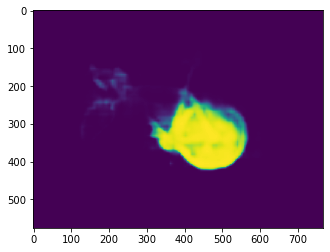

In [30]:
# Visualise
output_heatmap = output_proba[127]
plt.imshow(output_heatmap.asnumpy())

In [31]:
# Take most likely class for every pixel
prediction = mx.nd.argmax(output, 0).asnumpy()

print(prediction.shape) # prediction is single channelarray where each pixel values are class indexes

(576, 768)


In [32]:
print(prediction)

[[0. 0. 0. ... 4. 4. 4.]
 [0. 0. 0. ... 4. 4. 4.]
 [0. 0. 0. ... 4. 4. 4.]
 ...
 [3. 3. 3. ... 0. 0. 0.]
 [3. 3. 3. ... 0. 0. 0.]
 [3. 3. 3. ... 0. 0. 0.]]


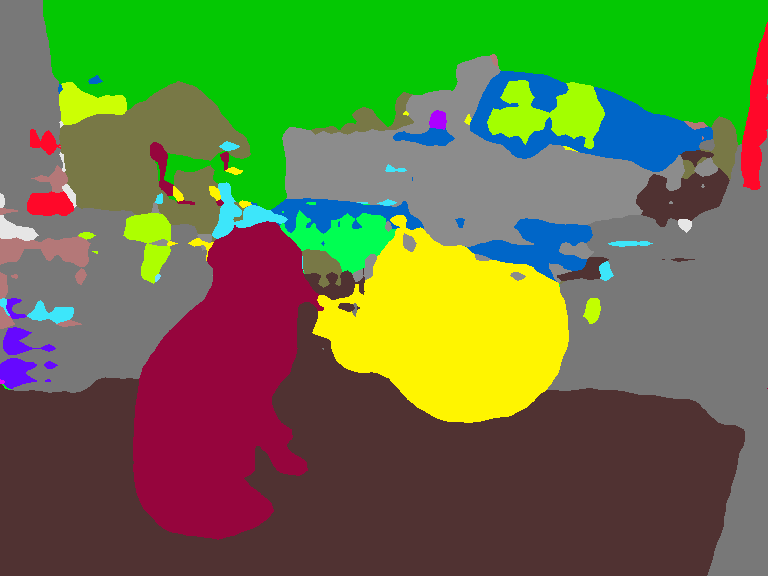

In [34]:
#Visualize
from gluoncv.utils.viz import get_color_pallete

prediction_image = get_color_pallete(prediction, 'ade20k')
prediction_image